# Assignment 1 (part II): Automatic Panorama Mosaicing

In [24]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

In [25]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)



the number of matches is 56


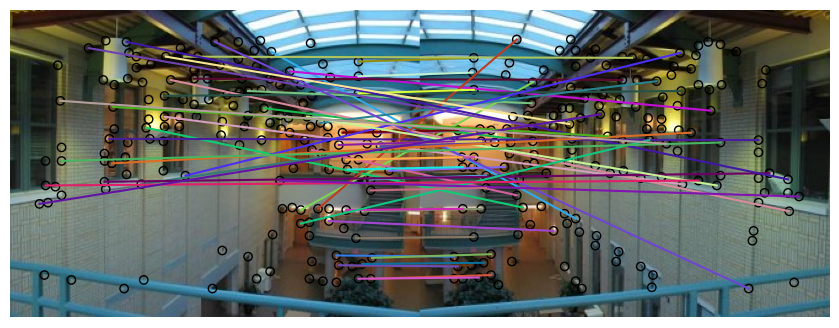

In [26]:
print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()
# save the plt as an image
fig.savefig('images/CMU_matches.jpg', dpi=300)

In [4]:
def blankImage(imL):
    imLalpha = imL.copy()
    imLalpha[:,:,0] = 0
    imLalpha[:,:,1] = 0
    imLalpha[:,:,2] = 0
    return imLalpha

enlargedL = blankImage(np.resize(imR,(imR.shape[0], imR.shape[1] * 2, 3)))
enlargedL[:,:imR.shape[1] ,0] = imL[:,:,0]
enlargedL[:,:imR.shape[1] ,1] = imL[:,:,1]
enlargedL[:,:imR.shape[1] ,2] = imL[:,:,2]

enlargedR = blankImage(np.resize(imR,(imR.shape[0] , imR.shape[1] * 2, 3)))
enlargedR[:,:imR.shape[1] ,0] = imR[:,:,0]
enlargedR[:,:imR.shape[1] ,1] = imR[:,:,1]
enlargedR[:,:imR.shape[1] ,2] = imR[:,:,2]

In [5]:
imR.shape

(251, 334, 3)

In [6]:
dst = np.roll( keypointsL[matchesLR[:,0]], 1, axis = 1)
src = np.roll( keypointsR[matchesLR[:,1]], 1, axis = 1) 
#src = src + imL.shape[1]*np.column_stack((np.zeros(len(src)),np.ones(len(src))))

In [7]:
model_robust, inliers = ransac((src, dst),  ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=1000000)
model_robust.params

array([[ 5.99577004e-01,  3.44287291e-03,  2.44639819e+02],
       [-1.55624940e-01,  9.66296216e-01,  7.63672537e+00],
       [-1.34336668e-03,  1.23496645e-04,  1.00000000e+00]])

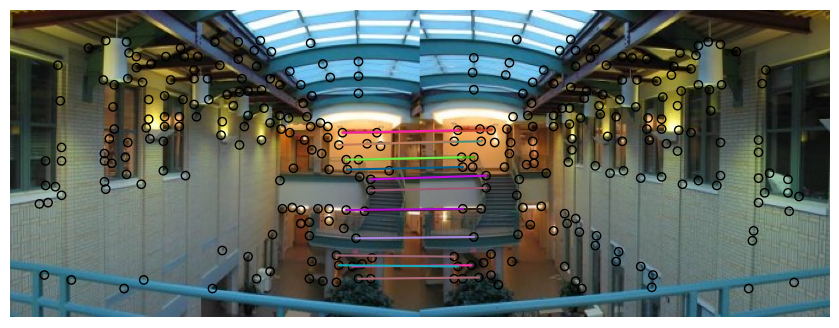

In [8]:
fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR[inliers]) #, matches_color = 'r')
axA.axis('off')

plt.show()

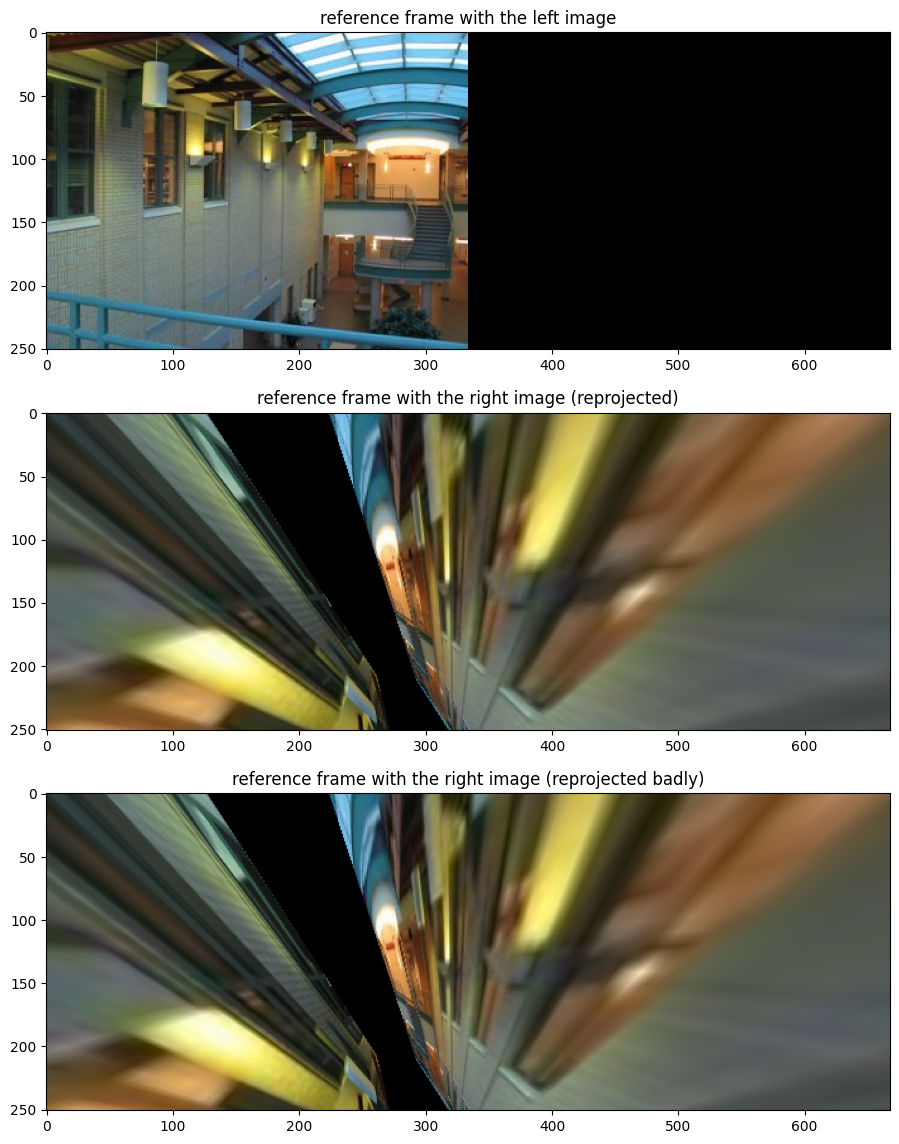

In [27]:
fig = plt.figure(3,figsize = (12, 14))

plt.subplot(311)

plt.imshow(enlargedL)
plt.title("reference frame with the left image")

plt.subplot(312)

transformedRight =  warp(enlargedR, model_robust.inverse)
transformedRight = (transformedRight * 255).astype(int)
plt.imshow(transformedRight)
plt.title("reference frame with the right image (reprojected)")


plt.subplot(313)
model_bad = ProjectiveTransform()
model_bad.estimate(src, dst)
plt.imshow( warp(enlargedR, model_bad.inverse))
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

In [10]:
np.max(transformedRight)

255

In [11]:
def boundaryDT(image):
    length = image.shape[1]
    height = image.shape[0]

    a = np.fromfunction(lambda i,j: i, 
                (height,length), 
                dtype = int)
    b = np.fromfunction(lambda i,j: j, 
                (height,length), 
                dtype = int)
    c = height - 1 + np.fromfunction(lambda i,j: -i, 
                (height,length), 
                dtype = int)
    d = length - 1 + np.fromfunction(lambda i,j: -j, 
                (height,length), 
                dtype = int)
    
    # got no idea how to merge the 4 matricies please look at piazza @20
    mask = np.minimum(np.minimum(a,b),np.minimum(c,d)) + 1
    return mask / np.max(mask)

In [12]:
enlargedR_1 = blankImage(np.resize(imR,(imR.shape[0] , imR.shape[1]  * 2, 3)))
enlargedR_1[:,:imR.shape[1] ,0] = imR[:,:,0]
enlargedR_1[:,:imR.shape[1] ,1] = imR[:,:,1]
enlargedR_1[:,:imR.shape[1] ,2] = imR[:,:,2]

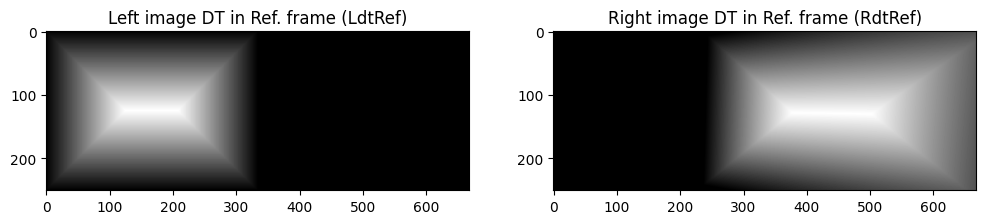

In [13]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.title("Left image DT in Ref. frame (LdtRef)")


imL_dtrans =np.zeros((imL.shape[0] , imL.shape[1]  * 2))
imL_dtrans[:,:imL.shape[1]] = boundaryDT(imL)

plt.imshow(imL_dtrans)


plt.subplot(122)
plt.title("Right image DT in Ref. frame (RdtRef)")
imR_dtrans = imL_dtrans.copy()
imR_dtrans = warp(imR_dtrans, model_robust.inverse)
#plt.imshow(img_2_alpha)
plt.imshow( imR_dtrans)

In [14]:
def calculateAlpha(dtransP, dtransS):
    alpha =dtransP[:] / (dtransP[:] + dtransS[:])
    m = np.isnan(alpha) # mask of NaNs
    alpha[m] = 0
    return alpha

In [15]:
def applyAlpha(image,alpha):
    imagealpha = image.copy()
    imagealpha[:,:,0] = np.multiply(alpha,image[:,:,0])
    imagealpha[:,:,1] = np.multiply(alpha,image[:,:,1])
    imagealpha[:,:,2] = np.multiply(alpha,image[:,:,2])
    return imagealpha

In [16]:
alphaL = calculateAlpha(imL_dtrans,imR_dtrans)
alphaR = calculateAlpha(imR_dtrans,imL_dtrans)

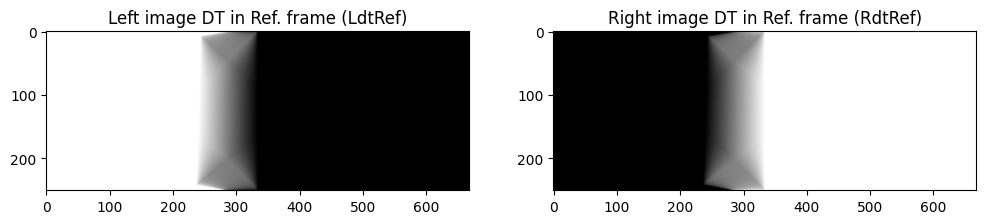

In [17]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.title("Left image DT in Ref. frame (LdtRef)")


plt.imshow(alphaL )


plt.subplot(122)
plt.title("Right image DT in Ref. frame (RdtRef)")

plt.imshow(alphaR)

In [18]:
alphaL.shape

(251, 668)

In [19]:
enlargedL.shape

(251, 668, 3)

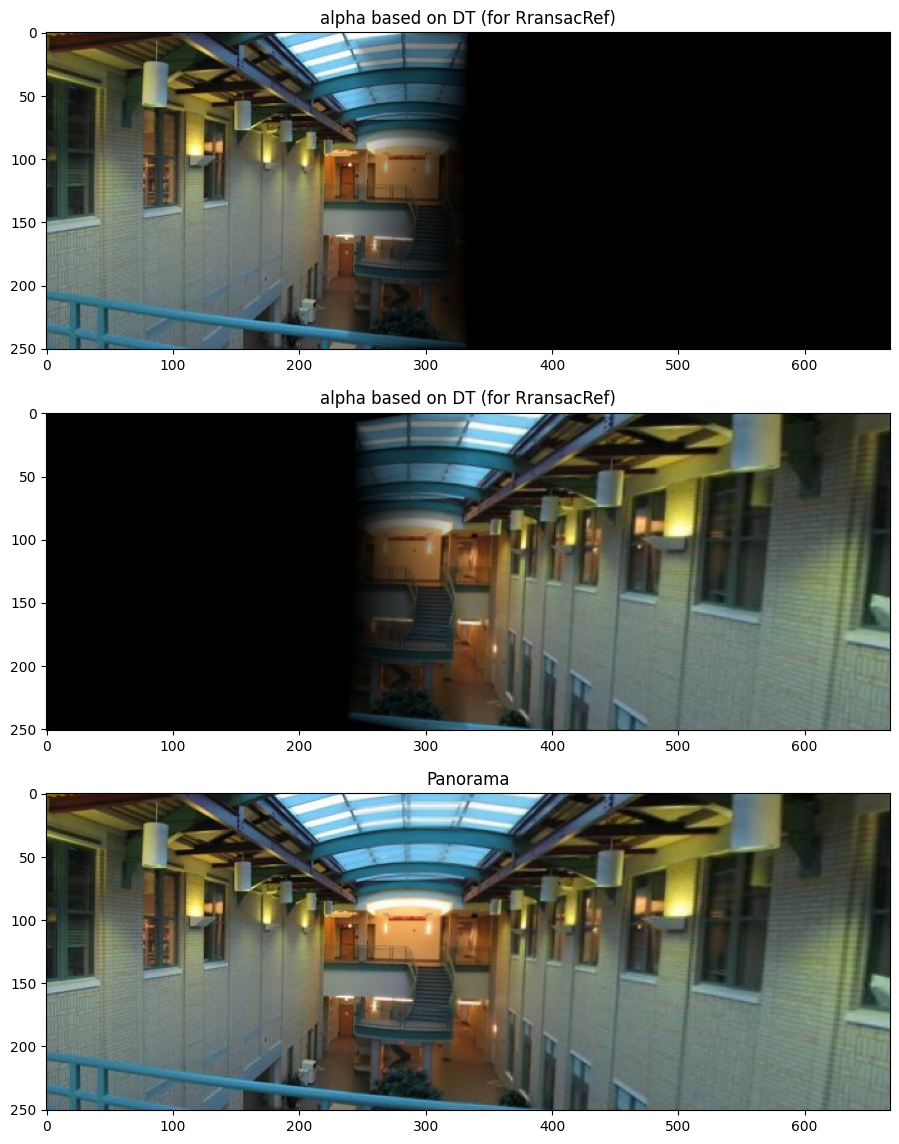

In [20]:
fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)

img_1 = applyAlpha(enlargedL,alphaL)


plt.imshow(img_1)

plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
#plt.imshow(...)

img_2R = applyAlpha(transformedRight,alphaR)
    
    
plt.imshow(img_2R)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(313)
Panorama = img_2R + img_1
plt.imshow(Panorama)
plt.title("Panorama")

plt.show()